In [1]:
import os 
import sys 

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import torch  
import minari 
import numpy as np

from utils.sampling_states import sample_states
from models.cl_model import mlpCL
from data.TrajectorySet import TrajectorySet


In [2]:
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
DEVICE = "cpu"
PROJECT_ROOT = os.getcwd()
TOTAL_STATES = 1_000_000

In [3]:
# Get all 4 models 

model_name_1 = "best_model_laplace_15.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_1) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    laplace_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_2 = "best_model_gaussian_15_p2.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_2) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    gauss_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_3 = "best_model_exponential.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_3) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    expo_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_4 = "best_model_uniform.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_4) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    uniform_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\best_model_laplace_15.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\best_model_gaussian_15_p2.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\best_model_exponential.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\best_model_uniform.ckpt, loading...


In [4]:
# Get states from dataset
d = sample_states(MINARI_DATASET, TOTAL_STATES,)

# Preprocessor

In [5]:
def process_states(states) -> list: 
    """
    Takes in raw states and returns its corresponding 2D PCA embedding. 
    Args: 
        states: The raw states, of size [N, d]
    
    Returns: 
        A list of PCA embeddings from the 4 models in this order: 
        [pca_laplace, pca_gauss, pca_expo, pca_uniform]
    """
    # Convert subsampled states to latent represntation 
    new_states = torch.as_tensor(states, dtype=torch.float32)

    with torch.no_grad():
        laplace_z = laplace_model(new_states)
        gauss_z = gauss_model(new_states)
        expo_z = expo_model(new_states) 
        uniform_z = uniform_model(new_states)

    # Normalize representation embeddings 
    scaler_laplace = StandardScaler()
    scaler_gauss = StandardScaler()
    scaler_expo = StandardScaler()
    scaler_uniform = StandardScaler()

    norm_laplace_z = scaler_laplace.fit_transform(laplace_z)
    norm_gauss_z = scaler_gauss.fit_transform(gauss_z)
    norm_expo_z = scaler_expo.fit_transform(expo_z)
    norm_uniform_z = scaler_uniform.fit_transform(uniform_z)

    # PCA 
    pca_laplace_model = PCA(n_components=2)
    pca_gauss_model   = PCA(n_components=2)
    pca_expo_model    = PCA(n_components=2)
    pca_uniform_model = PCA(n_components=2)

    pca_laplace = pca_laplace_model.fit_transform(norm_laplace_z)
    pca_gauss = pca_gauss_model.fit_transform(norm_gauss_z)
    pca_expo = pca_expo_model.fit_transform(norm_expo_z)
    pca_uniform = pca_uniform_model.fit_transform(norm_uniform_z)

    return {"pca-reps": [pca_laplace, pca_gauss, pca_expo, pca_uniform], 
            "pca-models": [pca_laplace_model, pca_gauss_model, pca_expo_model, pca_uniform_model],
            "scalars": [scaler_laplace, scaler_gauss, scaler_expo, scaler_uniform]}


In [6]:
states = d["states"]

# Subsample from the states array so there isn't so much clutter on visualization
idx = np.random.choice(np.arange(TOTAL_STATES), size=100_000, replace=False)
new_states = states[idx] 

pca_dict = process_states(new_states)

pca_states = pca_dict["pca-reps"]

#t1 = [x[0 : d["trajectory_idx"][0]] for x in pca_states] 
#t2 = [x[d["trajectory_idx"][0] : d["trajectory_idx"][1]] for x in pca_states]

#print(d["trajectory_idx"])

C:\Users\ray\AppData\Local\Temp\ipykernel_18276\1724922807.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


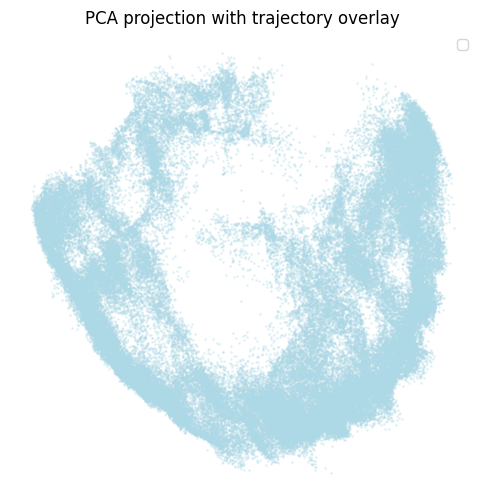

In [7]:
i = 1

plt.figure(figsize=(6,6))
plt.scatter(pca_states[i][:, 0], pca_states[i][:, 1], s=1, c="lightblue", alpha=0.25)
#plt.scatter(t1[i][:, 0], t1[i][:, 1], s=1, c="red")
#plt.scatter(t2[i][:, 0], t2[i][:, 1], s=1, c="green")


plt.axis("off")
plt.legend()
plt.title("PCA projection with trajectory overlay")
plt.show()

#plt.scatter(pca_gauss[:, 0], pca_gauss[:, 1], s=1, c="red", alpha=0.1)
#plt.scatter(pca_expo[:, 0], pca_expo[:, 1], s=1, c="green", alpha=0.1)
#plt.scatter(pca_uniform[:, 0], pca_uniform[:, 1], s=1, c="purple", alpha=0.1)



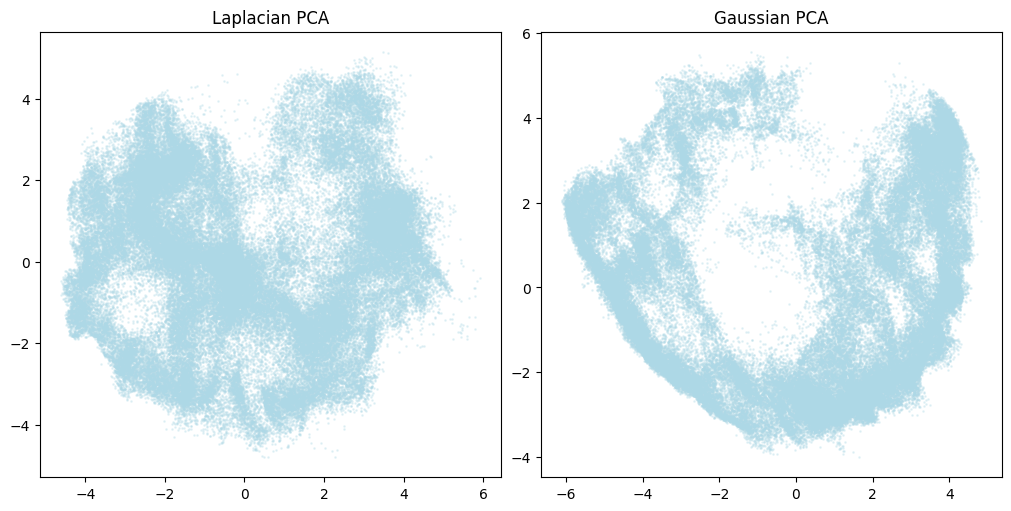

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)

axs[0].scatter(pca_states[0][:, 0], pca_states[0][:, 1], s=1, c="lightblue", alpha=0.25)
axs[0].set_title("Laplacian PCA")

axs[1].scatter(pca_states[1][:, 0], pca_states[1][:, 1], s=1, c="lightblue", alpha=0.25)
axs[1].set_title("Gaussian PCA")

plt.show()

In [9]:
def pca_transform(states, pca_dict, dist_idx, model) -> list[list]:
    """
    Transforms states into their pca transformation given an existing pca model to do so. 

    Args: 
        states: The input states to be PCA-ed
        pca_dict: The PCA information (models, scalars)
        dist_idx: The distribution to use: [laplace, gauss, expo, uniform]
        model: The model to use, which must correspond to the type of distribution. 
    
    Returns: 
        A [N, 2] list, which is the states being PCA-ed. 
    """

    pca_models = pca_dict["pca-models"]
    scalers = pca_dict["scalars"]

    pca_model = pca_models[dist_idx]
    scalar = scalers[dist_idx]

    with torch.no_grad(): 
        z = model(torch.as_tensor(states, dtype=torch.float32))

    scaled_z = (z - torch.as_tensor(scalar.mean_, dtype=z.dtype)) / torch.as_tensor(scalar.scale_, dtype=z.dtype)

    mean = torch.as_tensor(pca_model.mean_, dtype=torch.float32)
    centered_z = scaled_z - mean

    W = torch.as_tensor(pca_model.components_, dtype=torch.float32)

    y = torch.matmul(centered_z, W.T)

    return y

In [10]:
# Sample two trajectories with less than ep_len in length

n_episodes = 2
ep_len = 200

trajs = []
for i in range(n_episodes): 
    while True: 
        traj = MINARI_DATASET.sample_episodes(n_episodes=1)
        if len(traj[0].observations["observation"]) < ep_len: 
            trajs.append(traj)
            break


In [11]:
t1 = trajs[0][0].observations["observation"]
t2 = trajs[1][0].observations["observation"]

model = gauss_model
dist_idx = 1

y1 = pca_transform(t1, pca_dict, dist_idx=dist_idx, model=model)
y2 = pca_transform(t2, pca_dict, dist_idx=dist_idx, model=model)

C:\Users\ray\AppData\Local\Temp\ipykernel_18276\4048902853.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


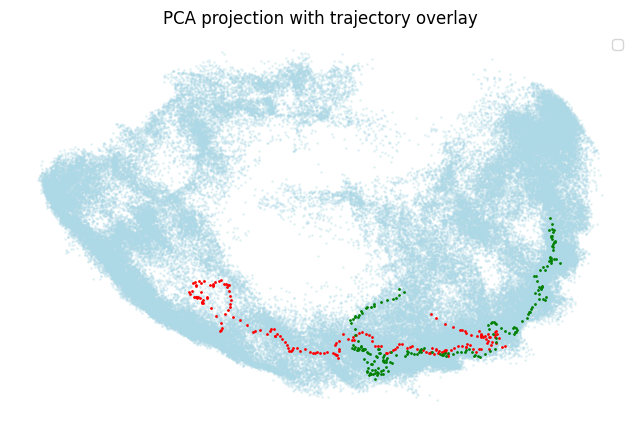

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(pca_states[dist_idx][:, 0], pca_states[dist_idx][:, 1], s=1, c="lightblue", alpha=0.25)
plt.scatter(y1[:, 0], y1[:, 1], s=1, c="red")
plt.scatter(y2[:, 0], y2[:, 1], s=1, c="green")


plt.axis("off")
plt.legend()
plt.title("PCA projection with trajectory overlay")
plt.show()